# Reconocimiento facial: python + tensorflow + keras

In [4]:
!pip install opencv-contrib-python

In [8]:
pip install matplotlib

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
DIR_CONOCIDOS = 'C:/Users/edsel/Documents/Hackathon 2020/Reconocimiento en R/Reconocimiento_facial_en_Python-master/Conocidos' #Cambia a la ruta donde hayas almacenado Data
DIR_DESCONOCIDOS = 'C:/Users/edsel/Documents/Hackathon 2020/Reconocimiento en R/Reconocimiento_facial_en_Python-master/Desconocidos'
DIR_RESULTADOS = 'C:/Users/edsel/Documents/Hackathon 2020/Reconocimiento en R/Reconocimiento_facial_en_Python-master/Resultados'

In [3]:
# Leer mobilenet_graph.pb
with tf.io.gfile.GFile('mobilenet_graph.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

In [4]:
print(mobilenet)

In [5]:
# Cargar imagen
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{name}'), cv2.COLOR_BGR2RGB)

In [6]:
def detect_faces(image, score_threshold=0.7):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    
    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')
    
    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes

In [7]:
# Dibujar bounding boxes
def draw_box(image,box,color,line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image,(box[0],box[2]),(box[1],box[3]),color,line_width)
    return image

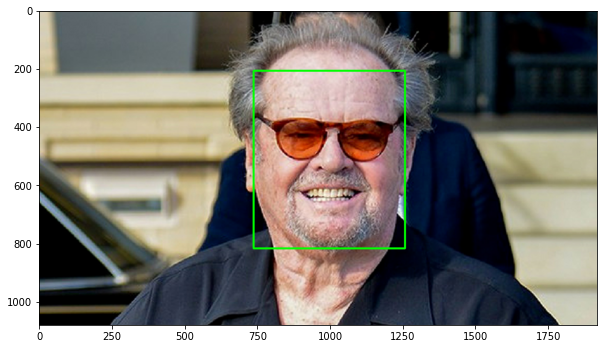

In [40]:
name = 'jack_nicholson_02.jpg'
image = load_image(DIR_DESCONOCIDOS,name)
bboxes = detect_faces(image)
for box in bboxes:
    detected_faces = draw_box(image,box,(0,255,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

In [41]:
# Extraer rostros
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

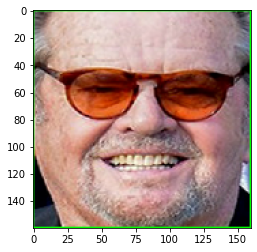

In [42]:
faces = extract_faces(image,bboxes)
plt.imshow(faces[0])

In [13]:
# FaceNet
facenet = load_model('facenet_keras.h5')
print(facenet.input_shape)
print(facenet.output_shape)

(None, 160, 160, 3)
(None, 128)


In [14]:
def compute_embedding(model,face):
    face = face.astype('float32')
    
    mean, std = face.mean(), face.std()
    face = (face-mean) / std
    
    face = np.expand_dims(face,axis=0)
    
    embedding = model.predict(face)
    return embedding

In [43]:
embedding = compute_embedding(facenet,faces[0])
print(embedding)

[[ 0.64161694  0.05387348 -0.21700485 -0.51771206  2.1566436  -0.35979635
  -0.5773888  -0.3881758   2.2443113  -0.08446132 -1.2721691  -0.37252888
   0.021971    0.6372988  -1.6677713   0.45474035 -0.60815537 -1.2862302
   0.49660677 -0.11633841  0.80752015  1.3770908  -0.4994011   1.4831512
   1.653681   -0.29860282  0.6483761   0.5237675   2.0295963  -0.21181847
  -0.2693226   0.09399278 -0.59089595 -0.14418921 -1.7286521  -0.65003216
  -0.74936825 -0.47855633 -1.0025647   0.03456195  1.0527728  -0.60377014
  -0.96193874  0.97946227  0.08734376  0.17871487 -1.6583736  -0.1708061
  -1.2098975   0.18855797 -0.81515765  0.6348153  -1.3105946  -0.19959366
  -1.6593862  -0.44438466  2.5890994  -2.521802   -1.5461829   0.0415714
   0.60642165  0.8359562  -0.83448166  0.6696927  -2.3797288   1.1961417
   0.98041594 -1.1035448  -0.06975517 -2.8659625  -1.3610122  -0.26119506
   0.7924989  -0.25928319  1.1155924  -0.12977272  1.1232295   0.7434025
   0.716074   -0.4096411  -1.8395491   2.141

In [44]:
# Embeddings referencia
known_embeddings = []

print('Procesando rostros conocidos...')
for name in os.listdir(DIR_CONOCIDOS):
    if name.endswith('.jpeg'):
        print(f'   {name}')
        image = load_image(DIR_CONOCIDOS,name)
        bboxes = detect_faces(image)
        face = extract_faces(image,bboxes)
        known_embeddings.append(compute_embedding(facenet,face[0]))             
       

Procesando rostros conocidos...
   Ga_01.jpeg
   Ga_02.jpeg
   Ga_03.jpeg
   Ga_04.jpeg


In [45]:
print(known_embeddings)

[array([[-7.85214007e-02, -5.97244620e-01,  7.87811697e-01,
        -4.50850166e-02,  4.55567747e-01,  1.43829226e+00,
         1.16011226e+00, -9.28281844e-02,  3.64895493e-01,
        -4.36165690e-01, -4.56302077e-01,  6.83128119e-01,
        -2.00173527e-01,  6.68709159e-01, -1.18127418e+00,
         1.06069303e+00,  7.61483431e-01,  2.13377908e-01,
        -1.06381536e-01, -1.32017994e+00, -4.59461361e-01,
        -3.09723318e-02, -5.23254216e-01, -2.13475084e+00,
         4.70537931e-01,  7.90280044e-01,  1.15116978e+00,
         1.16784468e-01, -5.52439451e-01,  7.80383706e-01,
         2.61699229e-01, -2.85832733e-01,  6.34381711e-01,
        -1.35943055e+00,  3.55982661e-01, -2.83408344e-01,
        -2.57877350e-01,  1.57395363e+00, -3.45686048e-01,
         1.32415533e+00,  3.83871853e-01, -7.77189910e-01,
        -2.54174173e-01,  1.30015925e-01, -1.01873718e-01,
        -2.52310842e-01,  9.06795114e-02, -2.94509441e-01,
        -3.54503393e-01, -8.36738467e-01, -5.60750246e-

In [46]:
def compare_faces(embs_ref, emb_desc, umbral=11):
    distancias = []
    for emb_ref in embs_ref:
        distancias.append(np.linalg.norm(emb_ref-emb_desc))
    distancias = np.array(distancias)
    return distancias, list(distancias<=umbral)

In [49]:
# Reconocimiento (????) de rostros desconocidos

print('Procesando imágenes desconocidas...')
for name in os.listdir(DIR_DESCONOCIDOS):
    if name.endswith('.jpg'):
        print(f'   {name}')
        image = load_image(DIR_DESCONOCIDOS,name)
        bboxes = detect_faces(image)
        faces = extract_faces(image,bboxes)
        
        # Por cada rostro calcular embedding
        img_with_boxes = image.copy()
        for face, box in zip(faces,bboxes):
            emb = compute_embedding(facenet,face)
            
            _, reconocimiento = compare_faces(known_embeddings,emb)
            
            if any(reconocimiento):
                var = 1
                img_with_boxes = draw_box(img_with_boxes,box,(0,255,0))
            else:
                img_with_boxes = draw_box(img_with_boxes,box,(255,0,0))
                var = 0
            
        cv2.imwrite(f'{DIR_RESULTADOS}/{name}',cv2.cvtColor(img_with_boxes,cv2.COLOR_RGB2BGR))
print('¡Fin!')                    
            
        
        
        

Procesando imágenes desconocidas...
   christian_bale_01.jpg
   christian_bale_02.jpg
   jack_nicholson_01.jpg
   jack_nicholson_02.jpg
   jack_nicholson_03.jpg
¡Fin!


In [ ]:
def Reconoce(nombre):
    if nombre==